# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Análise e Previsão de Séries Temporais com Inteligência Artificial</font>

## <font color='blue'>Lab 1 - Parte 6</font>
### <font color='blue'>Prevendo o Comportamento do Consumo de Energia ao Longo do Tempo e o Impacto na Economia</font>

![title](imagens/Lab1.png)

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.pyplot import figure

# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Filtrando FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas    : 1.5.3
sklearn   : 1.0.2
numpy     : 1.21.5
matplotlib: 3.5.2



## Carregando e Compreendendo os Dados

In [5]:
# Carrega os dados
dados_treino = pd.read_csv("dados/dataset_treino.csv")
dados_teste = pd.read_csv("dados/dataset_teste.csv")

#### Dados de Treino

In [6]:
# Shape
dados_treino.shape

(18288, 3)

In [7]:
# Primeiros registros
dados_treino.head()

id              data  consumo_energia
0   0  25-08-2020 00:00                8
1   1  25-08-2020 01:00                2
2   2  25-08-2020 02:00                6
3   3  25-08-2020 03:00                2
4   4  25-08-2020 04:00                2

In [8]:
# Últimos registros
dados_treino.tail()

id              data  consumo_energia
18283  18283  25-09-2022 19:00              868
18284  18284  25-09-2022 20:00              732
18285  18285  25-09-2022 21:00              702
18286  18286  25-09-2022 22:00              580
18287  18287  25-09-2022 23:00              534

In [9]:
# Tipos de dados
dados_treino.dtypes

id                  int64
data               object
consumo_energia     int64
dtype: object

#### Dados de Teste

In [10]:
# Shape
dados_teste.shape

(5112, 2)

In [11]:
# Primeiros registros
dados_teste.head()

id              data
0  18288  26-09-2022 00:00
1  18289  26-09-2022 01:00
2  18290  26-09-2022 02:00
3  18291  26-09-2022 03:00
4  18292  26-09-2022 04:00

In [12]:
# Últimos registros
dados_teste.tail()

id              data
5107  23395  26-04-2023 19:00
5108  23396  26-04-2023 20:00
5109  23397  26-04-2023 21:00
5110  23398  26-04-2023 22:00
5111  23399  26-04-2023 23:00

In [13]:
# Tipos
dados_teste.dtypes

id       int64
data    object
dtype: object

## Preparação dos Dados

In [14]:
# Converte a coluna de data para o tipo correto
dados_treino['data'] = pd.to_datetime(dados_treino.data, format = '%d-%m-%Y %H:%M')

In [15]:
# Verifica os tipos de dados
dados_treino.dtypes

id                          int64
data               datetime64[ns]
consumo_energia             int64
dtype: object

In [16]:
# Converte a coluna de data para o tipo correto
dados_teste['data'] = pd.to_datetime(dados_teste.data, format = '%d-%m-%Y %H:%M')

In [17]:
# Verifica os tipos de dados
dados_teste.dtypes

id               int64
data    datetime64[ns]
dtype: object

In [18]:
# Vejamos como ficou o dataset
dados_treino.head(5)

id                data  consumo_energia
0   0 2020-08-25 00:00:00                8
1   1 2020-08-25 01:00:00                2
2   2 2020-08-25 02:00:00                6
3   3 2020-08-25 03:00:00                2
4   4 2020-08-25 04:00:00                2

In [19]:
# Definimos o índice do dataset
dados_treino.index = dados_treino['data']

In [20]:
# Removemos a coluna ID, pois ela não é relevante neste caso
dados_treino.drop('id', axis = 1, inplace = True)

In [21]:
# Removemos a coluna data, pois ela não é relevante neste caso
dados_treino.drop('data', axis = 1, inplace = True)

In [22]:
# Variável target 
target = dados_treino['consumo_energia']

In [23]:
# Vejamos como ficou o dataset
dados_treino.head(5)

consumo_energia
data                                
2020-08-25 00:00:00                8
2020-08-25 01:00:00                2
2020-08-25 02:00:00                6
2020-08-25 03:00:00                2
2020-08-25 04:00:00                2

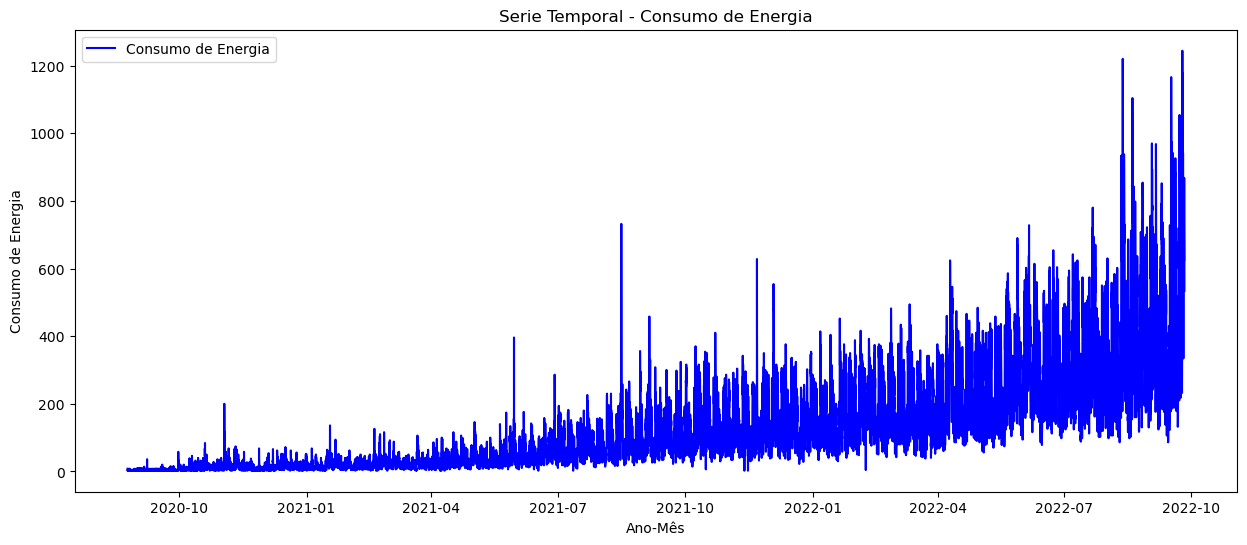

In [24]:
# Plot
figure(figsize = (15, 6))
plt.title("Serie Temporal - Consumo de Energia")
plt.plot(target, label = "Consumo de Energia", color = 'blue')
plt.xlabel("Ano-Mês")
plt.ylabel("Consumo de Energia")
plt.legend(loc = "best")

Percebemos que há claramente uma tendência de aumento no consumo de energia ao longo do tempo. 

## Pré-Processamento dos Dados

Vamos agora dividir os dados de treino em duas amostras, treino e validação. Usamos os dados de treino para treinar o modelo e os dados de validação para validar a performance do modelo antes de usar dados de teste.

Observe que os registros são separados em ordem cronológica, diferentemente o que fazemos com modelos de Machine Learning que não consideram a data como indexador. Para esses modelos queremos a divisão dos dados de forma aleatória. Em séries temporais, queremos a divisão em ordem cronológica, já que o tempo é um elemento de informação dos dados.

Não precisamos checar a estacionaridade da série, pois o primeiro método de Forecasting usado não faz suposições sobre a série temporal.

In [25]:
dados_treino.head()

consumo_energia
data                                
2020-08-25 00:00:00                8
2020-08-25 01:00:00                2
2020-08-25 02:00:00                6
2020-08-25 03:00:00                2
2020-08-25 04:00:00                2

In [26]:
# Os dados de treino serão divididos em dados de treino e validação
df_treino = dados_treino.iloc[0:16057]
df_valid = dados_treino.iloc[16058:]

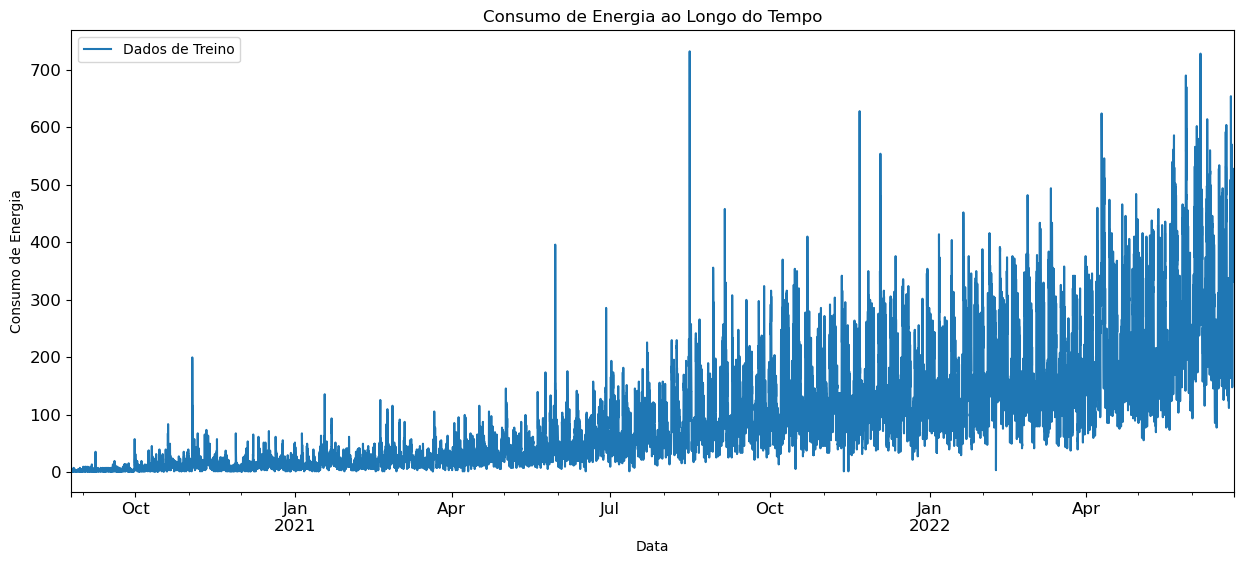

In [27]:
# Plot
figure(figsize = (15, 6))
df_treino.consumo_energia.plot(title = 'Consumo de Energia ao Longo do Tempo', 
                               fontsize = 12, 
                               label = 'Dados de Treino') 
plt.xlabel("Data") 
plt.ylabel("Consumo de Energia") 
plt.legend(loc = 'best') 
plt.show()

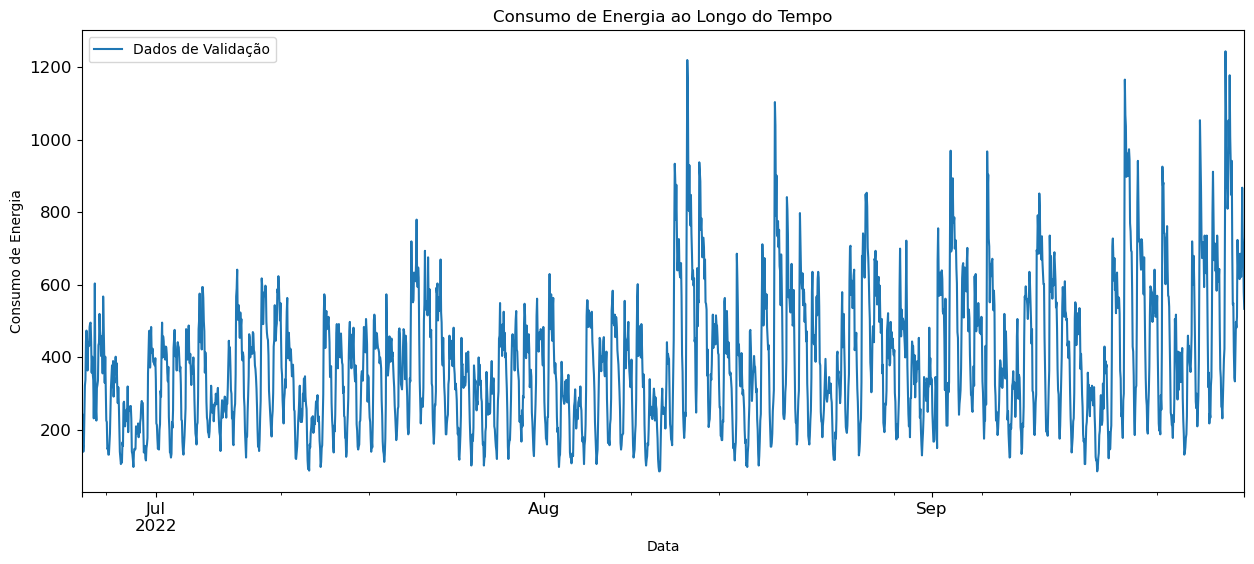

In [28]:
# Plot
figure(figsize = (15, 6))
df_valid.consumo_energia.plot(title = 'Consumo de Energia ao Longo do Tempo', 
                              fontsize = 12, 
                              label = 'Dados de Validação') 
plt.xlabel("Data") 
plt.ylabel("Consumo de Energia") 
plt.legend(loc = 'best') 
plt.show()

In [29]:
# Imports para análise de dados
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [30]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pandas     : 1.5.3
sklearn    : 1.0.2
statsmodels: 0.13.2
numpy      : 1.21.5
matplotlib : 3.5.2



In [31]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    
    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

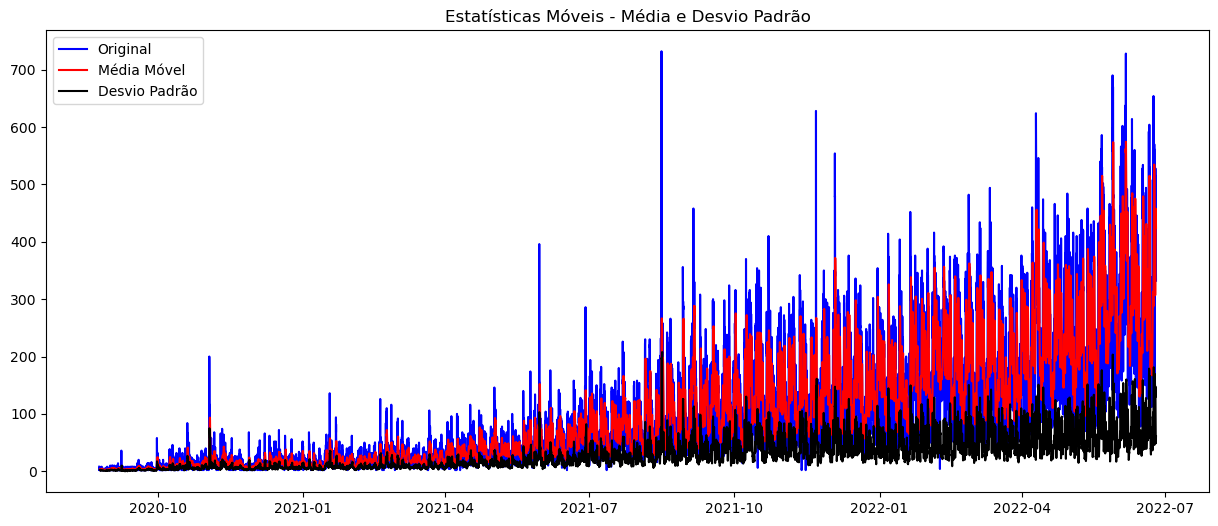


Resultado do Teste Dickey-Fuller:

Estatística do Teste               -5.038033
Valor-p                             0.000019
Número de Lags Consideradas        43.000000
Número de Observações Usadas    16013.000000
Valor Crítico (1%)                 -3.430758
Valor Crítico (5%)                 -2.861721
Valor Crítico (10%)                -2.566866
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [32]:
# Vamos testar a estacionaridade da série antes de qualquer transformação
figure(figsize = (15, 6))
testa_estacionaridade(df_treino)

## Forecasting - Modelagem Preditiva Para Séries Temporais

Criaremos alguns modelos para este problema que temos em mãos, aumentando o grau de complexidade a cada versão.

A primeira versão será a mais simples possível, que usaremos como benchmark.

### Implementando a Estratégia 1 de Forecasting - Método Naive

Técnica de estimativa na qual os dados reais do último período são usados como previsão desse período, sem ajustá-los ou tentar estabelecer fatores causais. É usado apenas para comparação com as previsões geradas pelas melhores técnicas (sofisticadas).

Naive = ingênuo

Não há técnica avançada aqui e apenas usamos como ponto de partida. Qualquer modelo mais avançado deve apresentar resultados superiores ao Método Naive.

In [33]:
type(df_treino)

pandas.core.frame.DataFrame

In [34]:
# Criamos um array com os valores da variável target em treino
array_consumo_energia_treino = np.asarray(df_treino.consumo_energia)

In [35]:
type(array_consumo_energia_treino)

numpy.ndarray

In [36]:
array_consumo_energia_treino

array([  8,   2,   6, ..., 352, 390, 332])

In [37]:
array_consumo_energia_treino.shape

(16057,)

In [38]:
# Cria uma cópia dos dados de validação para usar na comparação dos dados reais com as previsões
df_valid_cp = df_valid.copy()

Veja como o método é mesmo Naive

Os dados reais (de treino) são usados como previsão para os dados de validação, sem ajustá-los ou tentar estabelecer fatores causais.

In [39]:
len(array_consumo_energia_treino)

16057

In [40]:
# Previsão. Sim, isso é o Método Naive!
df_valid_cp['previsao_naive'] = array_consumo_energia_treino[len(array_consumo_energia_treino) - 1] 

In [41]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['consumo_energia', 'previsao_naive']].head()

consumo_energia  previsao_naive
data                                                
2022-06-25 02:00:00              218             332
2022-06-25 03:00:00              244             332
2022-06-25 04:00:00              168             332
2022-06-25 05:00:00              140             332
2022-06-25 06:00:00              156             332

In [42]:
# Colocamos lado a lado, valor real e valor "previsto"
df_valid_cp[['consumo_energia', 'previsao_naive']].tail()

consumo_energia  previsao_naive
data                                                
2022-09-25 19:00:00              868             332
2022-09-25 20:00:00              732             332
2022-09-25 21:00:00              702             332
2022-09-25 22:00:00              580             332
2022-09-25 23:00:00              534             332

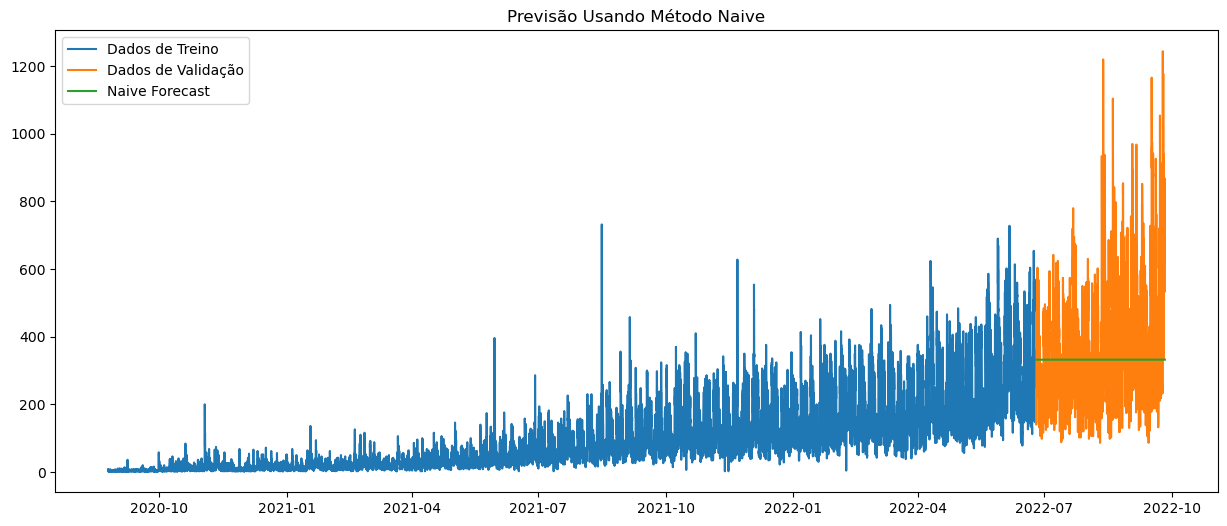

In [43]:
# Plot
figure(figsize = (15, 6))
plt.title("Previsão Usando Método Naive") 
plt.plot(df_treino.index, df_treino['consumo_energia'], label = 'Dados de Treino') 
plt.plot(df_valid.index, df_valid['consumo_energia'], label = 'Dados de Validação') 
plt.plot(df_valid_cp.index, df_valid_cp['previsao_naive'], label = 'Naive Forecast') 
plt.legend(loc = 'best') 
plt.show()

Observe que a linha amarela segue uma linha horizontal, sem considerar o padrão de comportamento da série ao longo do tempo. 

Ou seja, a previsão seria apenas um valor geral considerando o último valor dos dados de treino (dados históricos).

Como sabemos, o valor do título vai sofrer oscilações e é exatamente isso que desejamos prever, para então vender na alta e comprar na baixa, conseguindo algum lucro.

Esse é um método muito simples, mas que serve como ponto de partida. Qualquer técnica mais avançada deve apresentar uma performance melhor.

Então vamos trabalhar para criar um modelo robusto nas próximas aulas. Mas antes, vamos calcular a taxa de erro do modelo.

In [44]:
# Define valor real e valor previsto
y_true = df_valid_cp.consumo_energia
y_pred = df_valid_cp.previsao_naive

In [45]:
# Calcula o erro usando RMSE (Root Mean Squared Error)
metrica_rmse = sqrt(mean_squared_error(y_true, y_pred)) 
print(metrica_rmse)

195.06210118417584


RMSE é a taxa de erro e quanto menor, melhor!

# Fim